# Zalo AI Challenge 2025 - Track 1 - Data Preprocessing

## 1. Import thư viện cần thiết

In [ ]:
import os
import json
import cv2
import random
import yaml
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import numpy as np

def seed_everything(seed=42):
    # Python
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Đảm bảo deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Gọi hàm ngay khi khởi tạo notebook
seed_everything(42)

## 2. Tạo dataset phù hợp để train từ data được cung cấp

In [ ]:
# --- Configuration ---
BASE_DATASET_DIR = './Zalo_AIC25/Track1/train'
OUTPUT_DIR = './Zalo_AIC25/Track1/yolo_dataset_shuffle'
TRAIN_RATIO = 0.8
CLASS_ID = 0
CLASS_NAME = 'target_object'

In [ ]:
def convert_to_yolo(box, img_w, img_h):
    """
    Chuyển đổi tọa độ tuyệt đối (x1, y1, x2, y2) sang định dạng YOLO (x_center_norm, y_center_norm, width_norm, height_norm).
    """
    try:
        x1, y1, x2, y2 = float(box[0]), float(box[1]), float(box[2]), float(box[3])
        img_w, img_h = float(img_w), float(img_h)

        dw = 1.0 / img_w
        dh = 1.0 / img_h
        
        x_center = (x1 + x2) / 2.0
        y_center = (y1 + y2) / 2.0
        width = x2 - x1
        height = y2 - y1
        
        x_center_norm = x_center * dw
        y_center_norm = y_center * dh
        width_norm = width * dw
        height_norm = height * dh
        
        return (x_center_norm, y_center_norm, width_norm, height_norm)
    except Exception as e:
        print(f"Error in coordinate conversion: {e}")
        return None

In [ ]:
def process_frame(cap, frame_num, boxes, video_id, split_name, img_w, img_h, output_base_dir):
    """
    Đọc từng khung hình và lưu nó cùng với thông tin dạng YOLO của nó.
    """
    
    output_images_dir = os.path.join(output_base_dir, 'images', split_name)
    output_labels_dir = os.path.join(output_base_dir, 'labels', split_name)

    # Đến từng khung hình cụ thể
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    
    if not ret:
        print(f" Warning: Frame {frame_num} of video {video_id} could not be read from video.")
        return

    # Tạo tên file dựa trên video_id và frame_num
    file_basename = f"{video_id}_frame_{frame_num:06d}"
    image_path = os.path.join(output_images_dir, f"{file_basename}.jpg")
    label_path = os.path.join(output_labels_dir, f"{file_basename}.txt")
    
    # Lưu hình ảnh
    cv2.imwrite(image_path, frame)
    
    # Lưu thông tin dạng YOLO
    with open(label_path, 'w') as f:
        for box in boxes:
            # Chuyển đổi sang định dạng YOLO
            yolo_coords = convert_to_yolo(box, img_w, img_h)
            
            if yolo_coords:
                x_c, y_c, w, h = yolo_coords
                # Ghi vào file nhãn
                f.write(f"{CLASS_ID} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

In [ ]:
def create_yaml_file(output_dir, class_name):
    """Tạo file dataset.yaml cần thiết cho YOLO."""

    # Lấy đường dẫn tuyệt đối cho file YAML
    train_path = os.path.abspath(os.path.join(output_dir, 'images', 'train'))
    val_path = os.path.abspath(os.path.join(output_dir, 'images', 'val'))
    
    yaml_content = {
        'train': train_path,
        'val': val_path,
        'nc': 1,  # Số lớp
        'names': [class_name]  # Danh sách tên lớp
    }
    
    yaml_path = os.path.join(output_dir, 'dataset.yaml')
    
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)
    
    print(f"\nSuccessfully created {yaml_path}")
    print("This file points to your training and validation data.")

In [ ]:
# Hàm chính để xây dựng dataset
def build_dataset():
    annotations_file = os.path.join(BASE_DATASET_DIR, 'annotations', 'annotations.json')
    samples_dir = os.path.join(BASE_DATASET_DIR, 'samples')
    
    if not os.path.exists(annotations_file):
        print(f"Error: Annotation file not found at {annotations_file}")
        return
        
    if not os.path.exists(samples_dir):
        print(f"Error: Samples directory not found at {samples_dir}")
        return
        
    # Tạo tất cả các thư mục đầu ra
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'train'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'images', 'val'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'train'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, 'labels', 'val'), exist_ok=True)

    # Load tất cả các bản annotation record
    print("Loading annotations...")
    with open(annotations_file, 'r') as f:
        try:
            all_video_records = json.load(f)
        except json.JSONDecodeError as e:
            print(f"Error: Could not parse annotations.json. Invalid JSON: {e}")
            return
            
    if not isinstance(all_video_records, list):
         print(f"Error: Expected annotations.json to contain a list of video records.")
         return

    random.seed(42) # Sử dụng seed cố định để chia dữ liệu có thể tái tạo

    print("Processing videos and splitting frames...")
    # Lặp qua từng video
    for record in tqdm(all_video_records, desc="Processing Videos"):
        video_id = record['video_id']
        video_path = os.path.join(samples_dir, video_id, 'drone_video.mp4')
        
        if not os.path.exists(video_path):
            print(f"Warning: Video file not found, skipping: {video_path}")
            continue

        # 1. Nhóm tất cả các annotation theo số khung hình cho video này.
        frames_to_process = {}
        for interval in record.get('annotations', []):
            for bbox_data in interval.get('bboxes', []):
                try:
                    frame_num = int(bbox_data['frame'])
                    box = (
                        int(bbox_data['x1']),
                        int(bbox_data['y1']),
                        int(bbox_data['x2']),
                        int(bbox_data['y2'])
                    )
                    
                    if frame_num not in frames_to_process:
                        frames_to_process[frame_num] = []
                    frames_to_process[frame_num].append(box)
                except KeyError as e:
                    print(f"Warning: Missing key {e} in bbox data for {video_id}, skipping box.")
                except Exception as e:
                    print(f"Warning: Error processing bbox data for {video_id}: {e}, skipping box.")
        
        if not frames_to_process:
            continue
            
        # 2. Mở video và lấy thuộc tính của nó
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Could not open video {video_path}, skipping.")
            continue
            
        video_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        video_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        if video_width == 0 or video_height == 0:
            print(f"Error: Could not get dimensions for video {video_path}, skipping.")
            cap.release()
            continue

        # 3. Xáo trộn danh sách các khung hình cho video này và chia thành train/val
        frame_items = list(frames_to_process.items())
        random.shuffle(frame_items) # Shuffle frame trước khi chia
        split_index = int(len(frame_items) * TRAIN_RATIO)
        train_frames = frame_items[:split_index]
        val_frames = frame_items[split_index:]

        # 4. Xử lý và lưu khung hình vào các tập tương ứng
        for frame_num, boxes in train_frames:
            process_frame(cap, frame_num, boxes, video_id, 'train', video_width, video_height, OUTPUT_DIR)
            
        for frame_num, boxes in val_frames:
            process_frame(cap, frame_num, boxes, video_id, 'val', video_width, video_height, OUTPUT_DIR)
        
        cap.release()

    # Tạo file dataset.yaml cần thiết cho YOLO.
    create_yaml_file(OUTPUT_DIR, CLASS_NAME)
    
    print("\n--- Dataset generation complete! ---")
    print(f"Your YOLO dataset is ready in: {os.path.abspath(OUTPUT_DIR)}")

In [ ]:
# Gọi hàm để xây dựng dataset
build_dataset()

Loading annotations...
Processing videos and splitting frames...


Processing Videos: 100%|██████████| 14/14 [31:42<00:00, 135.93s/it]


Successfully created F:\Zalo_AIC25\Track1\yolo_dataset_shuffle\dataset.yaml
This file points to your training and validation data.

--- Dataset generation complete! ---
Your YOLO dataset is ready in: F:\Zalo_AIC25\Track1\yolo_dataset_shuffle


## 3. Trực quan hóa dữ liệu đã xử lý

In [ ]:
def denormalize_yolo(yolo_coords, img_w, img_h):
    """
    Chuyển đổi tọa độ chuẩn hóa của YOLO (x_center_norm, y_center_norm, width_norm, height_norm)
    trở lại tọa độ pixel tuyệt đối (x1, y1, x2, y2).
    """
    x_c_norm, y_c_norm, w_norm, h_norm = yolo_coords
    
    # Tính toán giá trị pixel từ các giá trị chuẩn hóa
    box_w = w_norm * img_w
    box_h = h_norm * img_h
    x_c = x_c_norm * img_w
    y_c = y_c_norm * img_h
    
    # Tính toán góc trên bên trái (x1, y1)
    x1 = int(x_c - (box_w / 2))
    y1 = int(y_c - (box_h / 2))
    
    # Tính toán góc dưới bên phải (x2, y2)
    x2 = int(x_c + (box_w / 2))
    y2 = int(y_c + (box_h / 2))
    
    return (x1, y1, x2, y2)

In [ ]:
def visualize_annotation(image_path, label_path):
    """
    Load hình ảnh và nhãn của nó, vẽ các bounding box và hiển thị nó
    """
    
    # Load hình ảnh sử dụng OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image at {image_path}")
        return
        
    img_h, img_w, _ = image.shape
    
    if not os.path.exists(label_path):
        print(f"Warning: No label file found at {label_path}")
    else:
        # Vẽ các bounding box lên hình ảnh
        with open(label_path, 'r') as f:
            for line in f:
                try:
                    # Đọc tọa độ YOLO
                    parts = line.strip().split()
                    yolo_coords = [float(p) for p in parts[1:]]
                    
                    # Chuẩn hóa tọa độ YOLO về tọa độ pixel tuyệt đối
                    x1, y1, x2, y2 = denormalize_yolo(yolo_coords, img_w, img_h)
                    
                    # Vẽ bbox lên hình ảnh (màu xanh lá cây, định dạng BGR)
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                                                    
                except Exception as e:
                    print(f"Error processing line '{line}': {e}")

    # Vẽ hình ảnh với matplotlib
    print(f"Displaying: {os.path.basename(image_path)}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

Displaying: Backpack_0_frame_003483.jpg


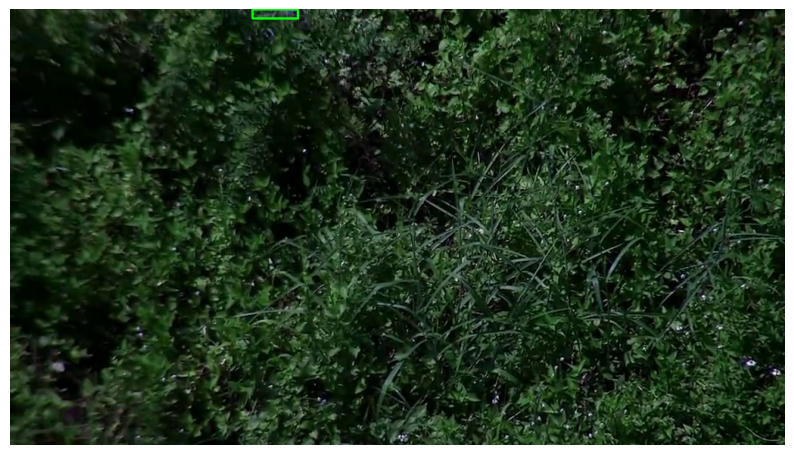

In [ ]:
YOLO_DATASET_DIR = OUTPUT_DIR
SPLIT_TO_CHECK = 'train'  # Có thể là 'train' hoặc 'val' để kiểm tra

images_dir = os.path.join(YOLO_DATASET_DIR, 'images', SPLIT_TO_CHECK)
labels_dir = os.path.join(YOLO_DATASET_DIR, 'labels', SPLIT_TO_CHECK)

# Lấy danh sách tất cả các hình ảnh
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
   
# Lấy 1 hình ảnh ngẫu nhiên
random_image_name = 'Backpack_0_frame_003483.jpg'
image_path = os.path.join(images_dir, random_image_name)

# Vẽ annotation cho hình ảnh đã chọn
label_name = os.path.splitext(random_image_name)[0] + '.txt'
label_path = os.path.join(labels_dir, label_name)
visualize_annotation(image_path, label_path)